In [0]:
from google.colab import files
uploaded=files.upload()

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline




In [0]:
k = 8                       
N = 16                     
train_SNR_Eb = 1           

nb_epoch = 2**12
code = 'polar'
nodes = [128, 64, 32]      
batch_size = 256       
LLR = False                
optimizer = 'adam'           
loss = 'mse'                

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

In [0]:
k = 8                       
N = 16                     
train_SNR_Eb = 1           

nb_epoch = 2**12      
code = 'polar'
nodes = [512,256,128]      
batch_size = 256       
LLR = False                
optimizer = 'adam'           
loss = 'mse'                

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

In [0]:
k = 8                 
N = 16                     
train_SNR_Eb = 1           

nb_epoch = 2**16          
code = 'random'
nodes = [128, 64, 32]      
batch_size = 256       
LLR = False                
optimizer = 'adam'           
loss = 'mse'                

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

In [0]:
k = 8                   
N = 16                  
train_SNR_Eb = 1           

nb_epoch = 2**12        
code = 'polar'
nodes = [128, 64, 32]      
batch_size = 256       
LLR = False                
optimizer = 'adam'           
loss = 'mse'                

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

In [0]:
k = 8                  
N = 16                     
train_SNR_Eb = 1           

nb_epoch = 2**12        
code = 'polar'
nodes = [128, 64, 32]      
batch_size = 256       
LLR = True              
optimizer = 'adam'           
loss = 'mse'                

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

In [0]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.cast(K.not_equal(y_true, K.round(y_pred)),'float32'))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return K.sum(K.cast(K.not_equal(y_true, K.round(y_pred)),'float32'))

In [0]:
# modulator
modulator_layers = [Lambda(modulateBPSK, 
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]
modulator = compose_model(modulator_layers)
modulator.compile(optimizer=optimizer, loss=loss)

# noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]
noise = compose_model(noise_layers)
noise.compile(optimizer=optimizer, loss=loss)

# LLR
llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                     input_shape=(N,), output_shape=return_output_shape, name="LLR")]
llr = compose_model(llr_layers)
llr.compile(optimizer=optimizer, loss=loss)

# decoder 
decoder_layers = [Dense(nodes[0], activation='relu', input_shape=(N,))]
for i in range(1,len(nodes)):
    decoder_layers.append(Dense(nodes[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

# model
if LLR:
    model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
else:
    model_layers = modulator_layers + noise_layers + decoder_layers
model = compose_model(model_layers)
model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

In [0]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    index = np.argsort(z0)
        
 
    index = np.sort(bitrevorder(index[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[index] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [0]:
# all possible information words
d = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

# sets of all possible codewords (codebook)
if code == 'polar':   
    
    L = polar_design_awgn(N, k, design_snr_dB=0)  # vector indicating the nonfrozen bit locations 
    x = np.zeros((2**k, N),dtype=bool)
    u = np.zeros((2**k, N),dtype=bool)
    u[:,L] = d

    for i in range(0,2**k):
        x[i] = polar_transform_iter(u[i])

elif code == 'random':
    
    np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

In [22]:
model.fit(x, d, batch_size=batch_size, nb_epoch=nb_epoch, verbose=0, shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


In [0]:
test_batch = 2000  
num_words = 200000     

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

In [9]:
result_map=0
if code=='polar':
  result_map=[[1.000000,   800000,    99463,   100000,    29498],
  [0.976965,   800000,    92809,   100000,    27316],
  [0.953931,   800000,    84622,   100000,    25020],
  [0.930896,   800000,    76647,   100000,    22735],
  [0.907861,   800000,    68530,   100000,    20458],
  [0.884827,   800000,    60749,   100000,    18207],
  [0.861792,   800000,    53272,   100000,    16016],
  [0.838757,   800000,    47885,   100000,    14211],
  [0.815723,   800000,    39644,   100000,    11931],
  [0.792688,   800000,    33407,   100000,    10081],
  [0.769653,   800000,    27958,   100000,     8480],
  [0.746619,   800000,    22746,   100000,     6965],
  [0.723584,   800000,    18070,   100000,     5490],
  [0.700549,   800000,    14290,   100000,     4322],
  [0.677515,   800000,    10778,   100000,     3284],
  [0.654480,   800000,     7794,   100000,     2383],
  [0.631445,   800000,     5532,   100000,     1737],
  [0.608411,   800000,     4057,   100000,     1209],
  [0.585376,   800000,     2407,   100000,      725],
  [0.562341,   800000,     1396,   100000,      438]]
else:
  result_map=[[1.264911,   500000,    59237,   100000,    22729],
  [1.235774,   500000,    54438,   100000,    20893],
  [1.206637,   500000,    50574,   100000,    19374],
  [1.177501,   500000,    46021,   100000,    17771],
  [1.148364,   500000,    41948,   100000,    16080],
  [1.119227,   500000,    37194,   100000,    14326],
  [1.090090,   500000,    33784,   100000,    13047],
  [1.060953,   500000,    29614,   100000,    11364],
  [1.031817,   500000,    25992,   100000,     9988],
  [1.002680,   500000,    22299,   100000,     8487],
  [0.973543,   500000,    19170,   100000,     7363],
  [0.944406,   500000,    15939,   100000,     6169],
  [0.915269,   500000,    13310,   100000,     5101],
  [0.886133,   500000,    10954,   100000,     4197],
  [0.856996,   500000,     8759,   100000,     3359],
  [0.827859,   500000,     6990,   100000,     2675],
  [0.798722,   500000,     5218,   100000,     1992],
  [0.769585,   500000,     3976,   100000,     1517],
  [0.740449,   500000,     3035,   100000,     1150],
  [0.711312,   500000,     2123,   100000,      800]]
  
result_map=np.array(result_map)
print(result_map)

[[1.00000e+00 8.00000e+05 9.94630e+04 1.00000e+05 2.94980e+04]
 [9.76965e-01 8.00000e+05 9.28090e+04 1.00000e+05 2.73160e+04]
 [9.53931e-01 8.00000e+05 8.46220e+04 1.00000e+05 2.50200e+04]
 [9.30896e-01 8.00000e+05 7.66470e+04 1.00000e+05 2.27350e+04]
 [9.07861e-01 8.00000e+05 6.85300e+04 1.00000e+05 2.04580e+04]
 [8.84827e-01 8.00000e+05 6.07490e+04 1.00000e+05 1.82070e+04]
 [8.61792e-01 8.00000e+05 5.32720e+04 1.00000e+05 1.60160e+04]
 [8.38757e-01 8.00000e+05 4.78850e+04 1.00000e+05 1.42110e+04]
 [8.15723e-01 8.00000e+05 3.96440e+04 1.00000e+05 1.19310e+04]
 [7.92688e-01 8.00000e+05 3.34070e+04 1.00000e+05 1.00810e+04]
 [7.69653e-01 8.00000e+05 2.79580e+04 1.00000e+05 8.48000e+03]
 [7.46619e-01 8.00000e+05 2.27460e+04 1.00000e+05 6.96500e+03]
 [7.23584e-01 8.00000e+05 1.80700e+04 1.00000e+05 5.49000e+03]
 [7.00549e-01 8.00000e+05 1.42900e+04 1.00000e+05 4.32200e+03]
 [6.77515e-01 8.00000e+05 1.07780e+04 1.00000e+05 3.28400e+03]
 [6.54480e-01 8.00000e+05 7.79400e+03 1.00000e+05 2.383

In [0]:
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros(len(sigmas),dtype=int)
nb_bits = np.zeros(len(sigmas),dtype=int)

for i in range(0,len(sigmas)):

    for ii in range(0,np.round(num_words/test_batch).astype(int)):
        
        # Source
        np.random.seed(0)
        d_test = np.random.randint(0,2,size=(test_batch,k)) 

        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N),dtype=bool)
            u_test = np.zeros((test_batch, N),dtype=bool)
            u_test[:,A] = d_test

            for iii in range(0,test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N),dtype=bool)
            for iii in range(0,test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2*x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

        if LLR:
            y_test = 2*y_test/(sigmas[i]**2)

        # Decoder
        nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
        nb_bits[i] += d_test.size

In [0]:

sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

The graph of BER vs SNR for polar codes at varying SNR of test data with SNR of noise in training data set fixed to 1.


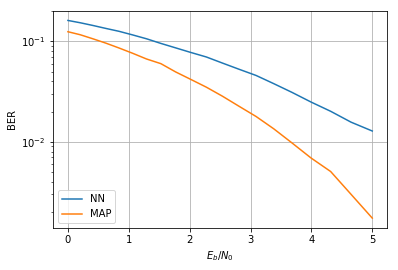

In [12]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP') 
print("The graph of BER vs SNR for polar codes at varying SNR of test data with SNR of noise in training data set fixed to 1.")
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()


The graph of BER vs SNR for random codes at varying SNR of test data with SNR of noise in training data set fixed to 1.


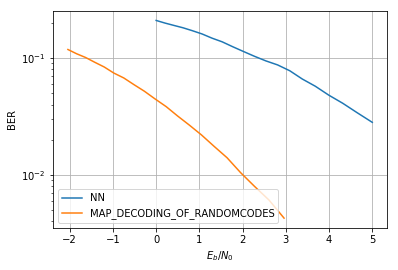

In [14]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP_DECODING_OF_RANDOMCODES') 
print("The graph of BER vs SNR for random codes at varying SNR of test data with SNR of noise in training data set fixed to 1.")
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()


The NVE without is:
2.3304514033113444
The graph of BER vs SNR(without LLR)for polar codes at varying SNR of test data with SNR of noise in training data set fixed to 1.


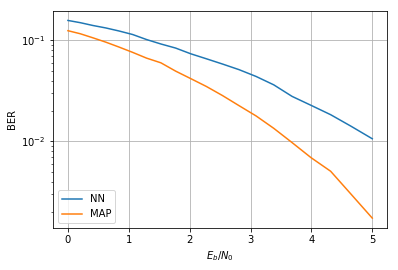

In [26]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
NVE=0
for i in range(len(nb_errors_map)):
  a=nb_errors[i]/nb_bits[i]
  b=nb_errors_map[i]/nb_bits_map[i]
  NVE+=(a/b)
NVE=(NVE/len(nb_errors_map))
legend.append('MAP')
print("The NVE without is:")
print(NVE)
print("The graph of BER vs SNR(without LLR)for polar codes at varying SNR of test data with SNR of noise in training data set fixed to 1.")
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()


The NVE using LLR is:
2.060227722657762
The graph of BER vs SNR for polar codes with LLR and 2**12 epochs at varying SNR of test data with SNR of noise in training data set fixed to 1.


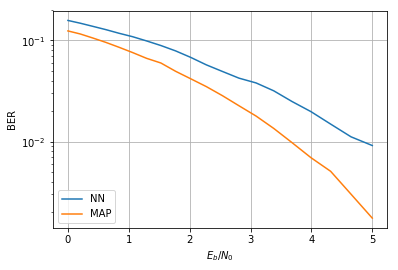

In [13]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN') 
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP') 
NVE=0
for i in range(len(nb_errors_map)):
  a=nb_errors[i]/nb_bits[i]
  b=nb_errors_map[i]/nb_bits_map[i]
  NVE+=(a/b)
NVE=(NVE/len(nb_errors_map))
print("The NVE using LLR is:")
print(NVE)
print("The graph of BER vs SNR for polar codes with LLR and 2**12 epochs at varying SNR of test data with SNR of noise in training data set fixed to 1.")
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()
